In [184]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(20, 10), dpi=80)
import operator
from utils import get_dfs, extract_classes

<Figure size 1600x800 with 0 Axes>

In [194]:
# hdf_file_path = "../data/20221029-134728.hdf5"
# hdf_file_path = "../data/20221029-170143.hdf5"
# hdf_file_path = "../data/20221029-171117.hdf5"
# hdf_file_path = "../data/20221029-200201.hdf5"
# hdf_file_path = "../data/20221029-192231.hdf5"
hdf_file_path = "../data/20221029-202757.hdf5"
(df_raw, df_events, df_filtered, df_bands) = get_dfs(hdf_file_path)

In [195]:
df_events

,label,data
2022-10-29 20:29:32.174300049,start,"""repos"""
2022-10-29 20:30:42.508399902,start,"""lent"""
2022-10-29 20:32:45.595000000,start,"""repos"""
2022-10-29 20:33:48.178800049,start,"""rapide"""
2022-10-29 20:35:53.861000000,start,"""repos"""
2022-10-29 20:36:57.444399902,start,"""rapide"""
2022-10-29 20:39:00.062899902,start,"""repos"""
2022-10-29 20:40:04.211399902,start,"""lent"""
2022-10-29 20:42:04.097399902,start,"""repos"""
2022-10-29 20:43:16.161500000,stop,"""repos"""


In [175]:
'''
edges:
    - source: sub:raw
    target: save:raw # will be saved in hdf (key '/raw')
    - source: sub:events
    target: save:events # will be saved in hdf (key '/events')
    - source: sub:filtered
    target: save:filtered # will be stored in hdf (key '/filtered')
    - source: sub:bands
    target: save:bands  # will be stored in hdf (key '/bands')
'''

# def get_dfs():
#     paths = ['/raw', '/events', '/filtered', '/bands']
#     result = []

#     for path in paths:
#         ts_df = pd.read_hdf(hdf_file_path, path)
#         result.append(ts_df)
#         if path == '/events' and 'stop' not in ts_df.label.values:
#             ts_df.loc[result[0].index[-1]] = ['stop', ts_df.data.values[-1]]
            
#     return (r for r in result)

def display_ts(ts_df, title):
    ts = ts_df.cumsum()
    ts.plot(title="Multiply the values for each row with the values from the previous row", figsize=(20, 10));
    ts_df.plot(title=title, figsize=(20, 10))
    plt.show()

def two_side_view(ts_df, title=""):
    curr_df = ts_df.copy()
    x = curr_df.index
    y1 = curr_df['Fpz'].values

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
    plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
    plt.ylim(curr_df.min().min()*2, curr_df.max().max()*2)
    plt.title(f'{title} (Two Side View)', fontsize=16)
    plt.hlines(y=0, xmin=np.min(curr_df.index), xmax=np.max(curr_df.index), linewidth=.5)
    plt.show()

def get_df_range_event(ts_df, event_df, d):
    start_events = event_df.loc[(event_df.data == d)]
    # display(event_df)
    # display(event_df.index)
    # print(start_events)
    ref_start_date = start_events.index[0]
    start = event_df.loc[(event_df.data == d) & (event_df.label == 'start')].index[0]
    end = event_df.loc[(event_df.data == d) & (event_df.label == 'stop')].index

    if len(end) == 0:
        # Get the row after ref_start_date
        end = event_df.index[event_df.index.get_loc(ref_start_date, method='ffill') + 1]
    else:
        end = end[0]

    print("range => ")
    print(end - start)

    return ts_df[start:end].head(1000)

# def extract_classes(df_events):
#     classes = []
#     for index, row in df_events.iterrows():
#         if row['label'] == 'start':
#             classes.append(row['data'])
#     return classes

def seasonal_decompose_ts(ts_df, title):
    result = sm.tsa.seasonal_decompose(ts_df, model='multiplicative')
    result.plot()
    plt.show()

def viz_by_class(ts_df, event_df):
    '''
        This function will plot the time series for each class
    '''
    classes = extract_classes(event_df)
    tmp_event_df = event_df.copy()
    fig, axes = plt.subplots(nrows=len(classes), ncols=1, figsize=(30, 50))

    for c in range(len(classes)):
        # print(c)
        # print(classes.index(c))
        ts = get_df_range_event(ts_df, tmp_event_df, classes[c])
        ts.plot(ax=axes[c], title=classes[c])
        if c < len(classes) - 2:
            tmp_event_df = tmp_event_df.drop(tmp_event_df.index[0])
        # classes[classes.index(c)] = ''

    fig.tight_layout()
    plt.show()
    

In [103]:
df_raw.index[-1]

Timestamp('2022-10-29 17:09:36.598090')

range => 
0 days 00:13:43.987199951
range => 
0 days 00:02:03.086600098
range => 
0 days 00:10:30.566500
range => 
0 days 00:02:05.682199951
range => 
0 days 00:07:22.300500
range => 
0 days 00:02:02.618500


/var/folders/s9/mx70pkk11bq2wl2cnrt6nfwc0000gn/T/ipykernel_17340/3609290028.py:55: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  end = event_df.index[event_df.index.get_loc(ref_start_date, method='ffill') + 1]
/var/folders/s9/mx70pkk11bq2wl2cnrt6nfwc0000gn/T/ipykernel_17340/3609290028.py:55: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  end = event_df.index[event_df.index.get_loc(ref_start_date, method='ffill') + 1]
/var/folders/s9/mx70pkk11bq2wl2cnrt6nfwc0000gn/T/ipykernel_17340/3609290028.py:55: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  end = event_df.index[event_df.index.get_loc(ref_start_date, method='ffill') + 1]


range => 
0 days 00:04:16.098600098
range => 
0 days 00:01:59.886000
range => 
0 days 00:01:12.064100098


/var/folders/s9/mx70pkk11bq2wl2cnrt6nfwc0000gn/T/ipykernel_17340/3609290028.py:55: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  end = event_df.index[event_df.index.get_loc(ref_start_date, method='ffill') + 1]


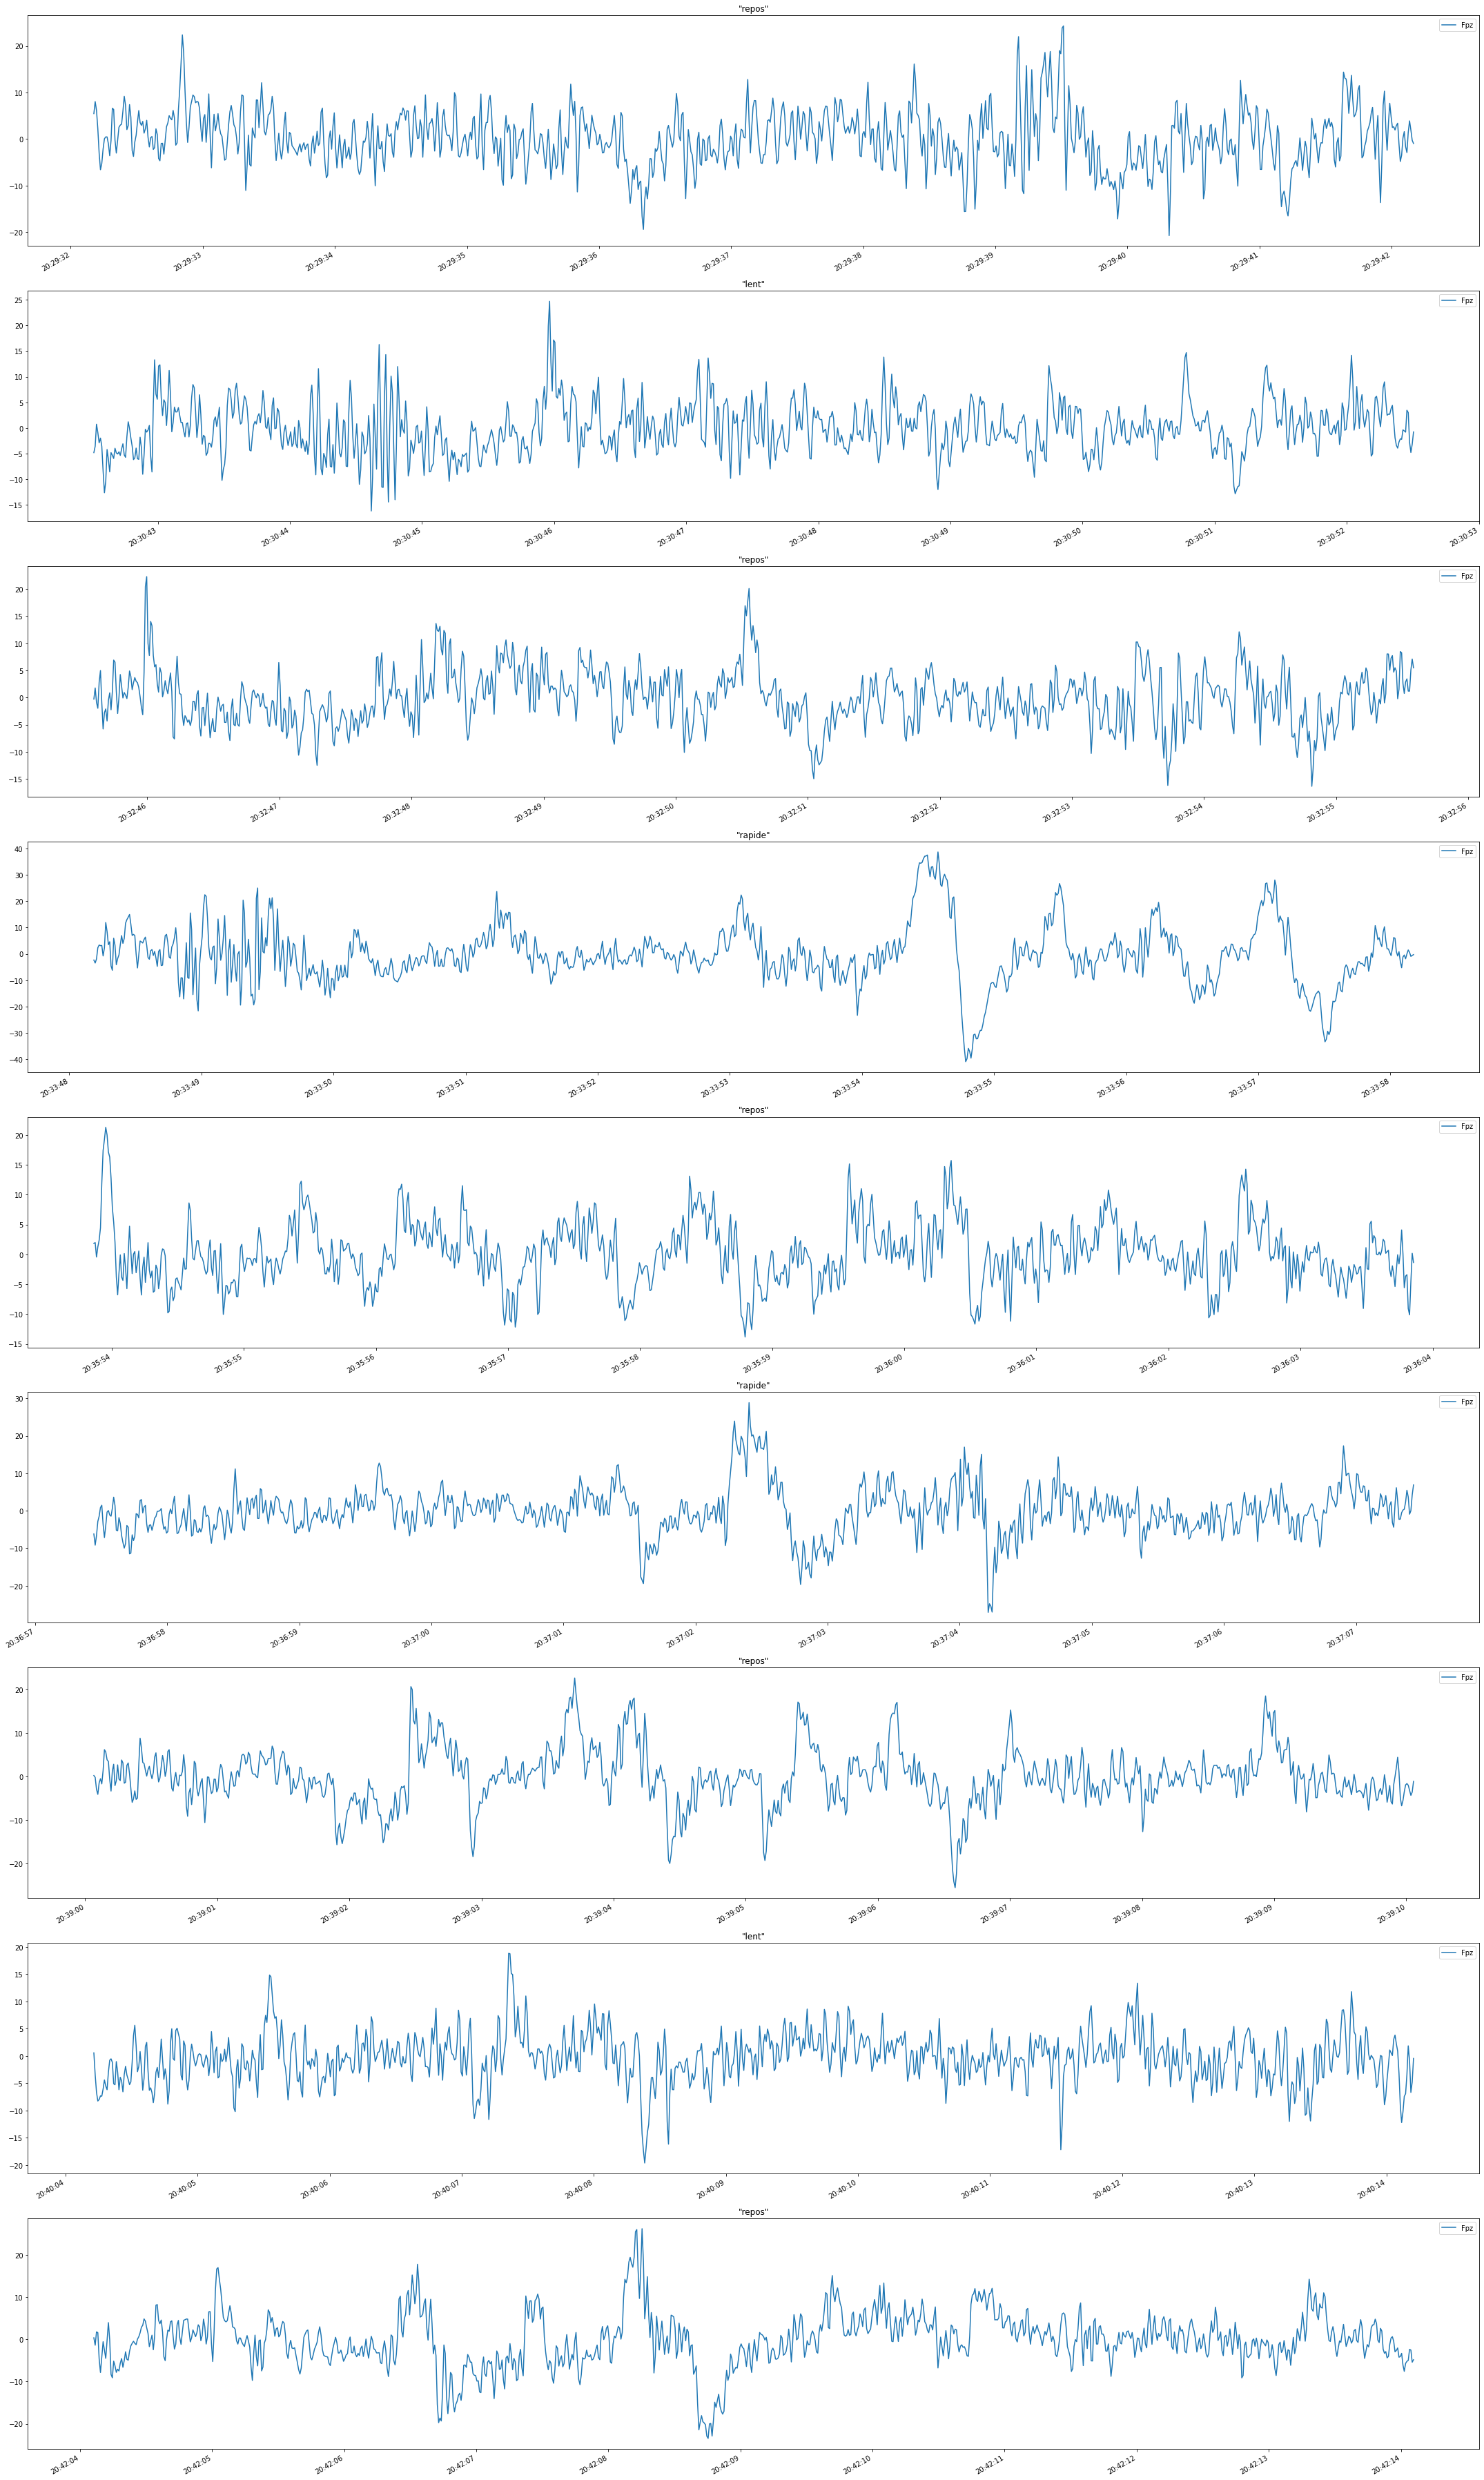

In [196]:
viz_by_class(df_filtered, df_events)

In [49]:
# Delete first row
tmp_event_df = df_events.copy()
tmp_event_df = tmp_event_df.drop(tmp_event_df.index[0])
display(tmp_event_df)
tmp_event_df = tmp_event_df.drop(tmp_event_df.index[0])
display(tmp_event_df)

,label,data
2022-10-29 17:04:21.812600098,start,"""lent"""
2022-10-29 17:05:12.345100098,start,"""repos"""
2022-10-29 17:06:06.943699951,start,"""rapide"""
2022-10-29 17:07:09.122899902,start,"""repos"""
2022-10-29 17:08:03.279899902,start,"""rapide"""
2022-10-29 17:08:58.087300049,start,"""interuption par charly"""


,label,data
2022-10-29 17:05:12.345100098,start,"""repos"""
2022-10-29 17:06:06.943699951,start,"""rapide"""
2022-10-29 17:07:09.122899902,start,"""repos"""
2022-10-29 17:08:03.279899902,start,"""rapide"""
2022-10-29 17:08:58.087300049,start,"""interuption par charly"""


In [156]:
(df_raw, df_events, df_filtered, df_bands) = get_dfs()

In [157]:
df_events

,label,data
2022-10-29 17:11:28.111000000,start,"""repos"""
2022-10-29 17:12:16.822699951,start,"""rapide"""
2022-10-29 17:13:23.859899902,start,"""repos"""
2022-10-29 17:14:01.688500000,start,"""lent"""
2022-10-29 17:14:58.447899902,start,"""rapide"""
2022-10-29 17:16:08.534000000,start,"""repos"""
2022-10-29 17:17:06.076899902,start,"""lent"""
2022-10-29 17:18:01.912300049,start,"""repos"""
2022-10-29 17:18:52.960600098,start,"""lent"""
2022-10-29 17:20:00.910899902,start,"""repos"""


In [ ]:
viz_by_class(df_filtered, df_events)

In [7]:
df_events

,label,data
2022-10-29 13:51:24.027500000,start,"""base"""
2022-10-29 13:51:39.196600098,start,"""base2"""
2022-10-29 13:52:14.838300049,start,"""base3"""
2022-10-29 13:52:41.032600098,stop,"""base3"""


Raw data


,Fpz
2022-10-29 17:01:44.688090,-36.868261
2022-10-29 17:01:44.698090,-29.155236
2022-10-29 17:01:44.708090,-39.490690
2022-10-29 17:01:44.718090,-33.166009
2022-10-29 17:01:44.728090,-34.631484
...,...
2022-10-29 17:09:36.558090,-18.742652
2022-10-29 17:09:36.568090,-21.210820
2022-10-29 17:09:36.578090,4.704945
2022-10-29 17:09:36.588090,7.404504


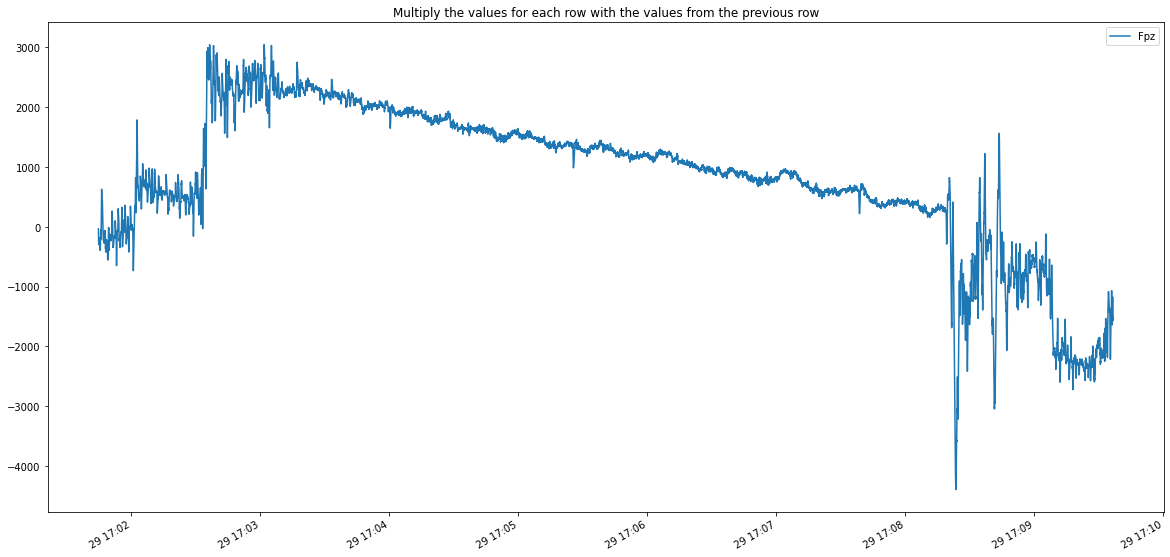

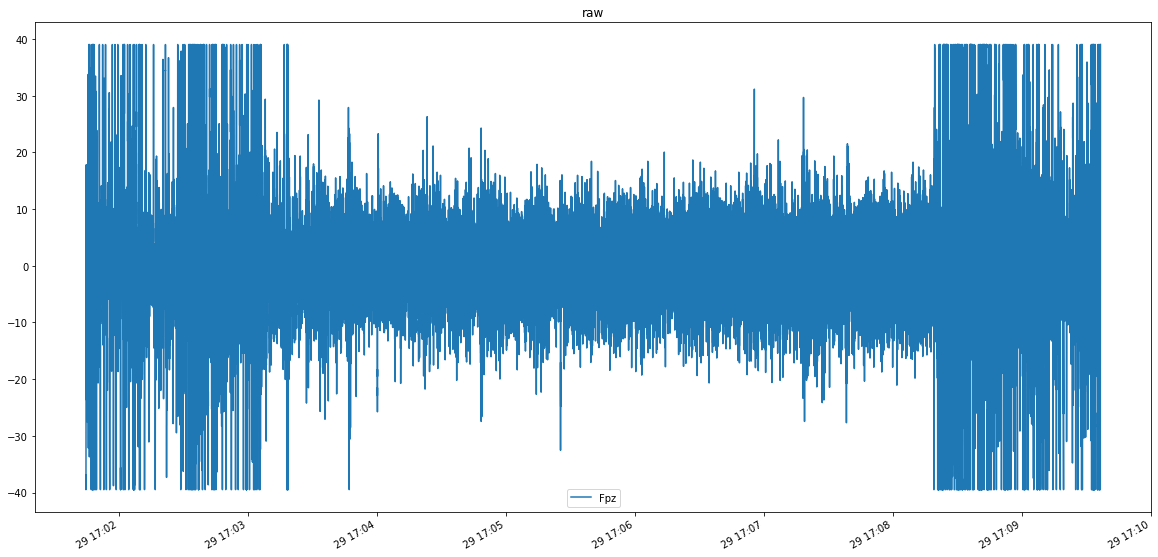

In [153]:
print("Raw data")
display(df_raw)
display_ts(df_raw, "raw")

Filtered data


,Fpz
2022-10-29 17:01:44.688090,0.000000
2022-10-29 17:01:44.698090,1.965779
2022-10-29 17:01:44.708090,4.075831
2022-10-29 17:01:44.718090,1.576172
2022-10-29 17:01:44.728090,0.476386
...,...
2022-10-29 17:09:36.498090,-41.177331
2022-10-29 17:09:36.508090,-40.771141
2022-10-29 17:09:36.518090,-40.957428
2022-10-29 17:09:36.528090,-40.100113


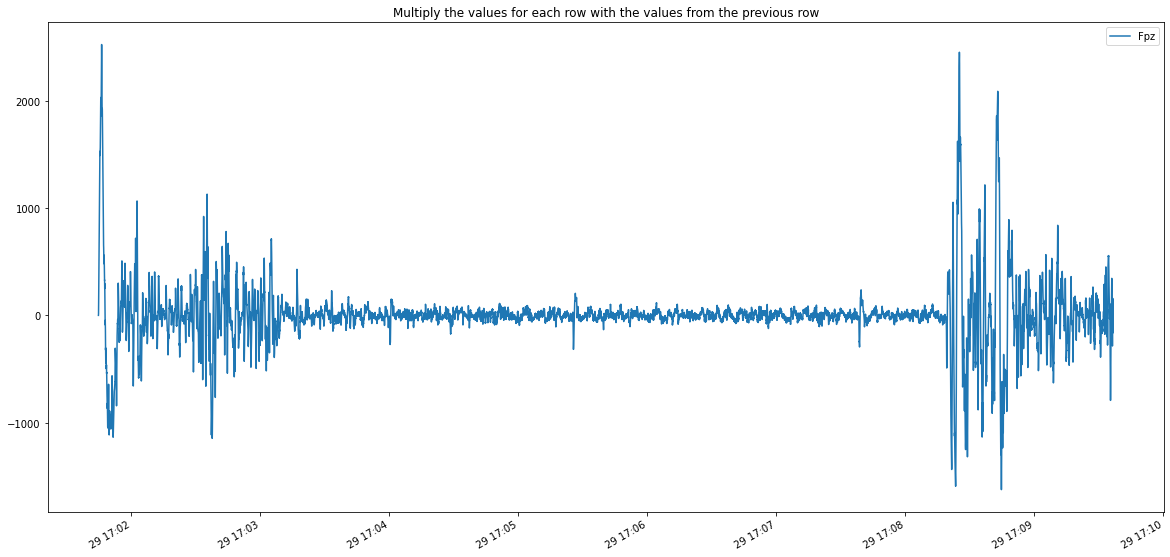

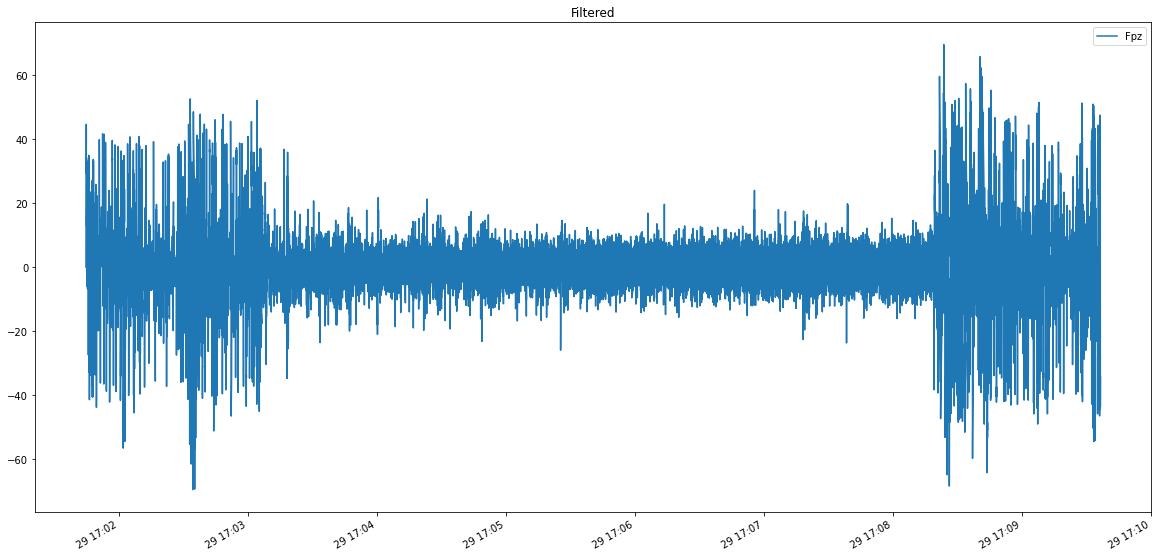

In [154]:
print("Filtered data")
display(df_filtered)
display_ts(df_filtered, "Filtered")

Bands data


,Fpz_delta,Fpz_theta,Fpz_alpha,Fpz_beta,Fpz_gamma
2022-10-29 17:01:47.728090,36.383476,3.258486,3.033662,2.206101,1.693306
2022-10-29 17:01:48.768090,34.041958,5.648308,5.956252,5.333748,2.597895
2022-10-29 17:01:49.708090,17.600056,5.951436,7.402978,9.564255,7.444584
2022-10-29 17:01:50.728090,27.315461,5.930099,8.465088,8.557542,6.533100
2022-10-29 17:01:51.768090,34.084011,5.841410,4.204750,3.580420,1.986963
...,...,...,...,...,...
2022-10-29 17:09:31.688090,21.369205,6.528479,3.002910,1.653504,0.625449
2022-10-29 17:09:32.728090,19.310093,5.543610,3.543242,4.779449,1.071533
2022-10-29 17:09:33.748090,35.536081,8.422275,8.840093,8.677347,2.630979
2022-10-29 17:09:34.778090,56.829527,11.847103,17.928370,14.724476,2.948844


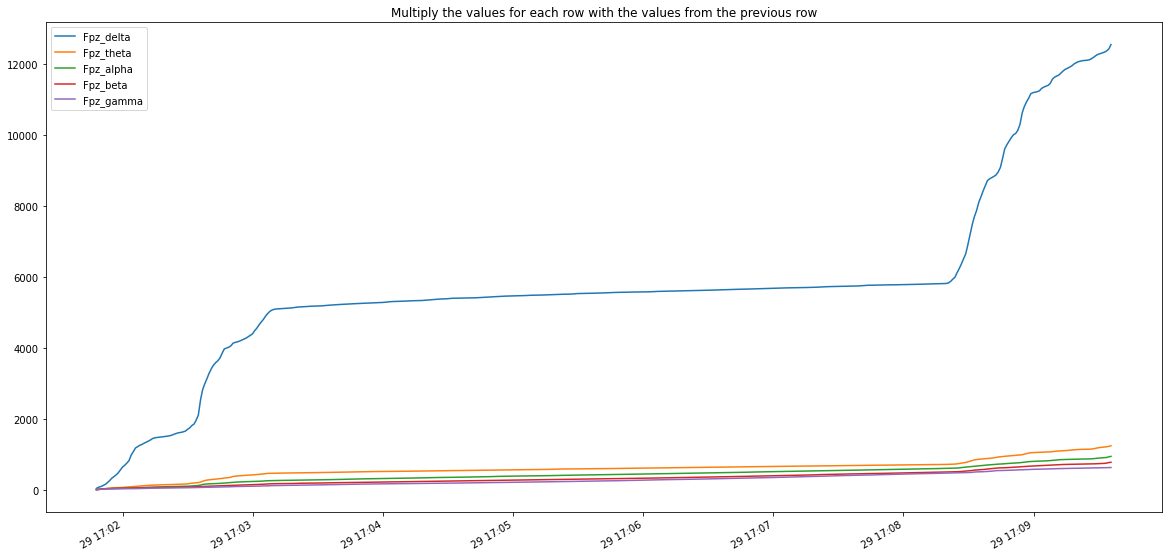

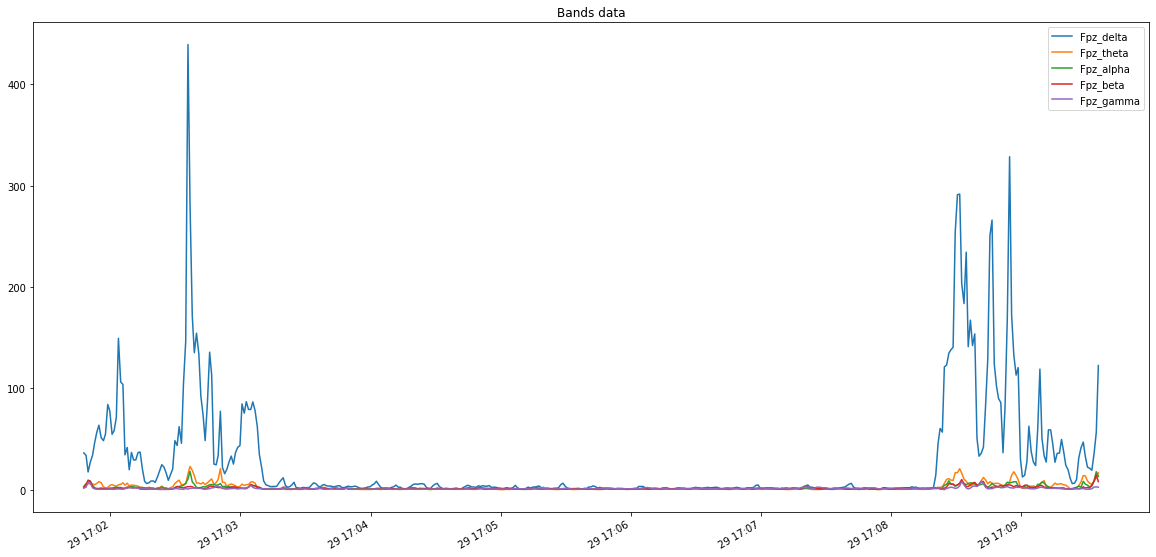

In [32]:
print("Bands data")
display(df_bands)
display_ts(df_bands, "Bands data")

In [11]:
tt_tmp = df_filtered.copy()
tt_tmp.index = pd.to_datetime(tt_tmp.index).to_period('ms')
display(tt_tmp.index)
# trend_analysis(tt_tmp)
tt_tmp = tt_tmp.mask(tt_tmp.lt(float(1))).ffill().fillna(float(1)).astype('int32')
# tt_tmp['Date'] = tt_tmp.index
# tt_tmp.index.freq = '10t'
# test_df_filtered = tt_tmp[['Date', 'Fpz']].copy()
# test_df_filtered.set_index('Date', inplace=True)
# test_df_filtered.index = pd.to_datetime(test_df_filtered.index)
# test_df_filtered.index.freq = '120t'
# test_df_filtered
# test_df_filtered.loc[test_df_filtered['Fpz'] <= 2]

PeriodIndex(['2022-10-29 13:47:31.382', '2022-10-29 13:47:31.392',
             '2022-10-29 13:47:31.402', '2022-10-29 13:47:31.412',
             '2022-10-29 13:47:31.422', '2022-10-29 13:47:31.432',
             '2022-10-29 13:47:31.442', '2022-10-29 13:47:31.452',
             '2022-10-29 13:47:31.462', '2022-10-29 13:47:31.472',
             ...
             '2022-10-29 13:55:06.702', '2022-10-29 13:55:06.712',
             '2022-10-29 13:55:06.722', '2022-10-29 13:55:06.732',
             '2022-10-29 13:55:06.742', '2022-10-29 13:55:06.752',
             '2022-10-29 13:55:06.762', '2022-10-29 13:55:06.772',
             '2022-10-29 13:55:06.782', '2022-10-29 13:55:06.792'],
            dtype='period[L]', length=45542)

In [12]:
import statsmodels.api as sm

tt_tmp = df_filtered.copy()
tt_tmp.index = pd.to_datetime(tt_tmp.index).to_period('ms')
display(tt_tmp)
tt_tmp = tt_tmp.mask(tt_tmp.lt(float(1))).ffill().fillna(float(1)).astype('int32')
# Multiplicative Decomposition 
result_mul = sm.tsa.seasonal_decompose(tt_tmp['Fpz'],  extrapolate_trend='freq', freq=3)

# Additive Decomposition
# result_add = sm.tsa.seasonal_decompose(tt_tmp['Fpz'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
# result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

,Fpz
2022-10-29 13:47:31.382,-4.440892e-15
2022-10-29 13:47:31.392,5.504182e-01
2022-10-29 13:47:31.402,2.448869e+00
2022-10-29 13:47:31.412,1.386845e+00
2022-10-29 13:47:31.422,-2.294194e+00
...,...
2022-10-29 13:55:06.752,3.758089e+00
2022-10-29 13:55:06.762,-1.635348e+00
2022-10-29 13:55:06.772,-4.920655e-01
2022-10-29 13:55:06.782,1.373207e+00


TypeError: seasonal_decompose() got an unexpected keyword argument 'freq'

,Fpz
2022-10-29 20:27:59.535,0.000000
2022-10-29 20:27:59.545,10.438289
2022-10-29 20:27:59.555,35.629969
2022-10-29 20:27:59.565,47.554233
2022-10-29 20:27:59.575,28.875561
...,...
2022-10-29 20:45:34.105,-1.974072
2022-10-29 20:45:34.115,-0.356100
2022-10-29 20:45:34.125,1.355186
2022-10-29 20:45:34.135,-4.522857


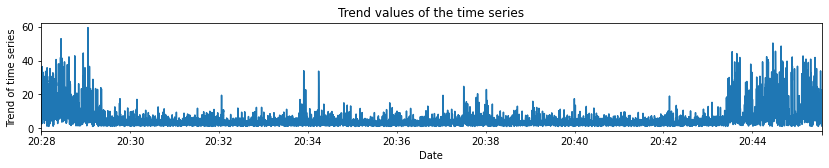

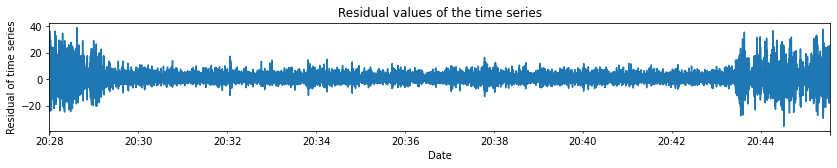

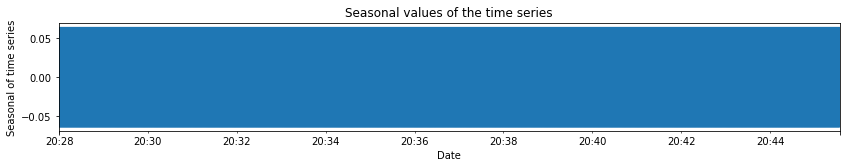

In [197]:
# date=['2016Q3'
# ,'2016Q4'
# ,'2017Q1'
# ,'2017Q1'
# ,'2017Q3'
# ,'2017Q4'
# ,'2018Q1'
# ,'2018Q3'
# ,'2018Q3'
# ,'2018Q4'
# ,'2019Q1'
# ,'2019Q2']

# data=[146660510.0
# ,123641451.0
# ,125905843.0
# ,129656327.0
# ,126586708.0
# ,116804168.0
# ,118167263.0
# ,121633740.0
# ,125314447.0
# ,120994896.0
# ,126124709.0
# ,134753318.0]

# df=pd.DataFrame({'date':date,'data':data})
# df['date']=pd.to_datetime(df['date'])
# df=df.set_index('date')
# ax=df.plot(figsize=(14,2))
# plt.show()



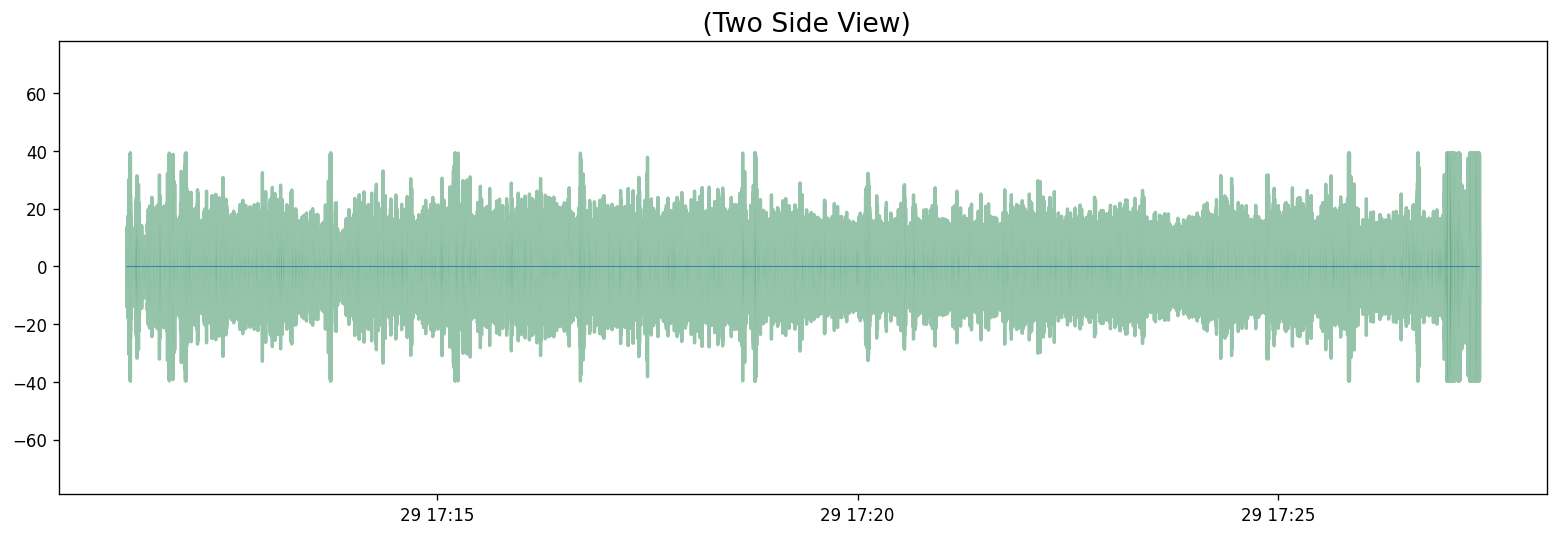

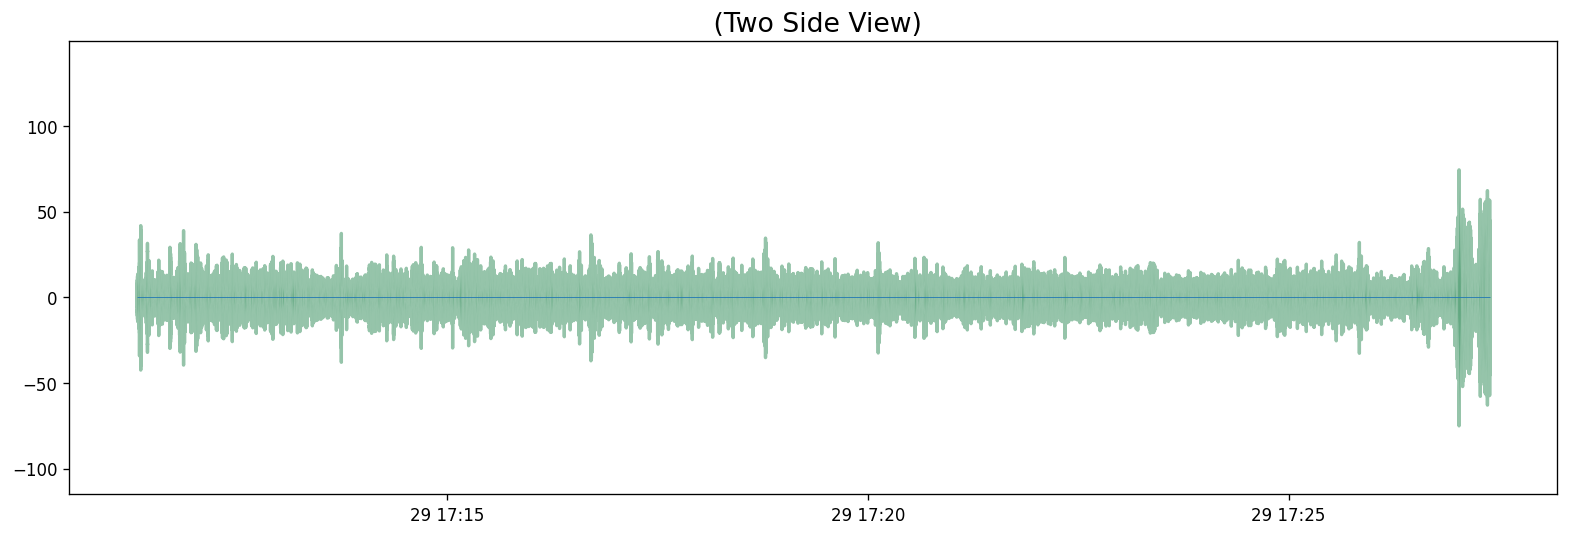

In [163]:
# tmp_df = df_raw.copy()
# x = tmp_df.index
# y1 = tmp_df['Fpz'].values

# # Plot
# fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
# plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
# plt.ylim(df_raw.min().min()*2, df_raw.max().max()*2)
# # plt.ylim(-800, 800)
# plt.title('Air Passengers (Two Side View)', fontsize=16)
# plt.hlines(y=0, xmin=np.min(tmp_df.index), xmax=np.max(tmp_df.index), linewidth=.5)
# plt.show()
two_side_view(df_raw)
two_side_view(df_filtered)

,Fpz
2022-10-29 17:11:18.410,-4.440892e-16
2022-10-29 17:11:18.420,2.575171e+00
2022-10-29 17:11:18.430,5.821741e+00
2022-10-29 17:11:18.440,2.818556e+00
2022-10-29 17:11:18.450,-4.639568e-01
...,...
2022-10-29 17:27:23.220,3.027611e+01
2022-10-29 17:27:23.230,3.447261e+01
2022-10-29 17:27:23.240,3.455183e+01
2022-10-29 17:27:23.250,3.221013e+01


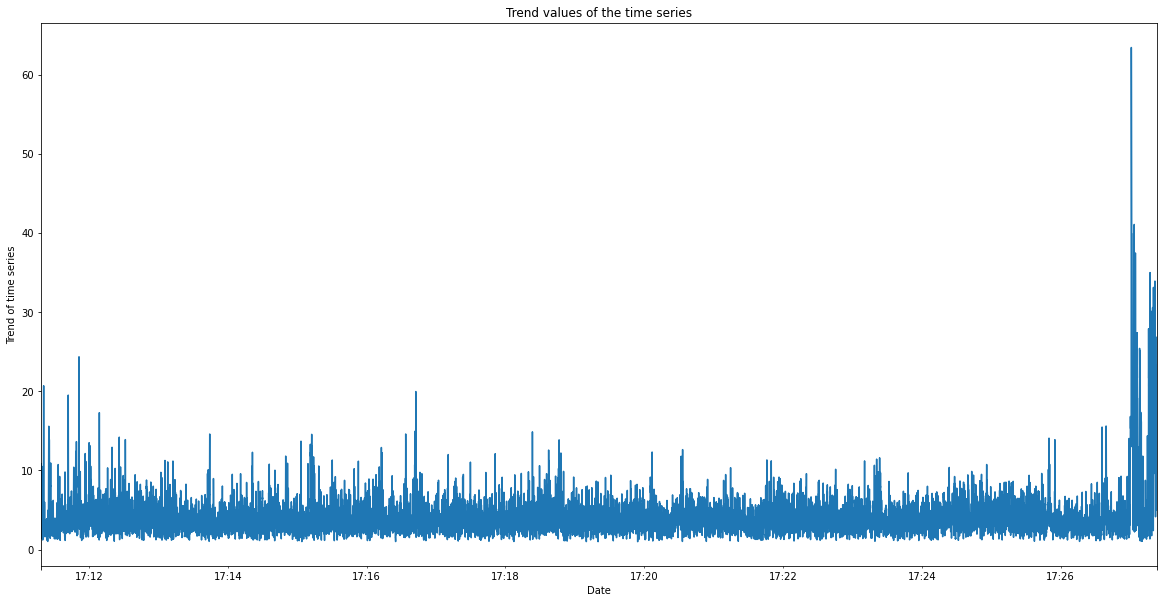

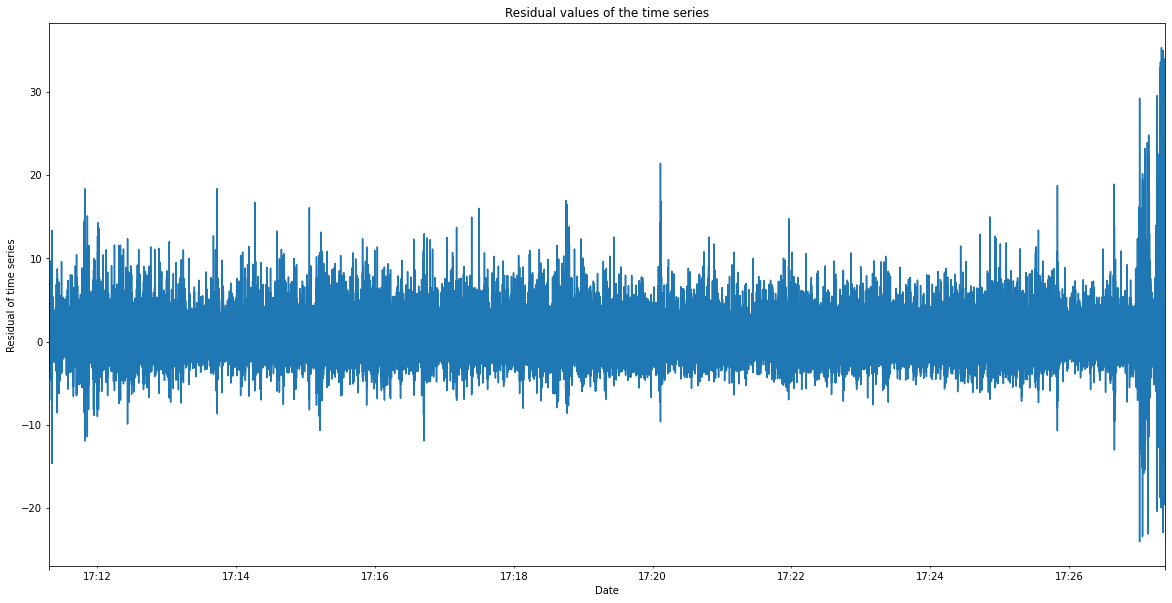

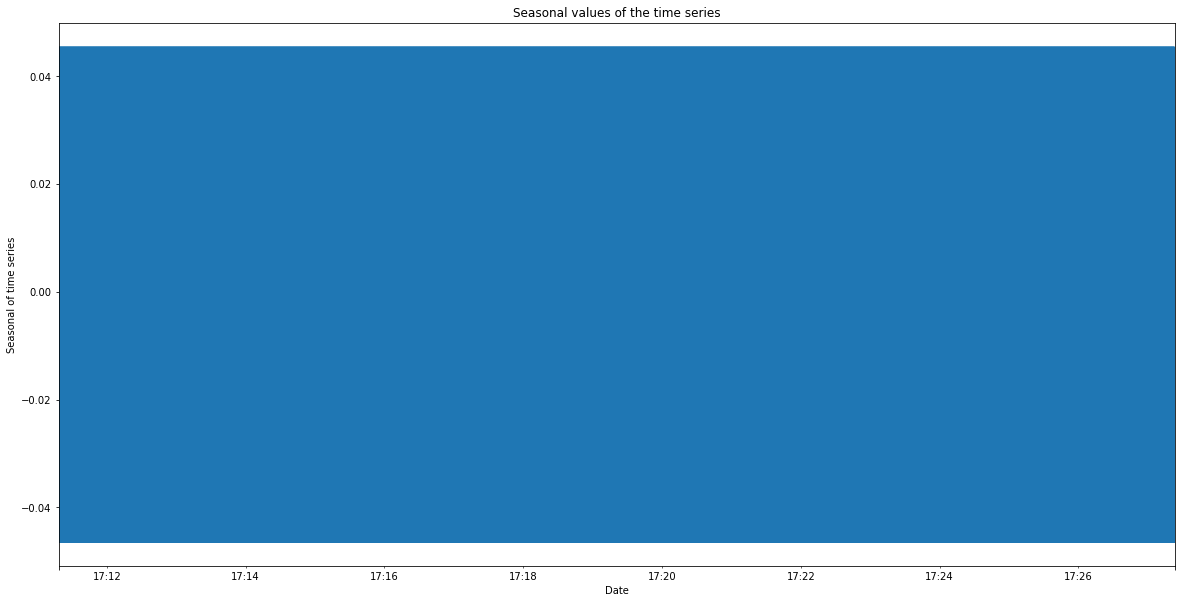

In [177]:

tt_tmp = df_filtered.copy()
tt_tmp.index = pd.to_datetime(tt_tmp.index).to_period('ms')
display(tt_tmp)
tt_tmp = tt_tmp.mask(tt_tmp.lt(float(1))).ffill().fillna(float(1)).astype('float32')

decomposition=sm.tsa.seasonal_decompose(x=tt_tmp['Fpz'],model='additive', extrapolate_trend='freq', period=13)

decomposition_trend=decomposition.trend
ax= decomposition_trend.plot(figsize=(20,10))
ax.set_xlabel('Date')
ax.set_ylabel('Trend of time series')
ax.set_title('Trend values of the time series')
plt.show()

decomposition_residual=decomposition.resid
ax= decomposition_residual.plot(figsize=(20,10))
ax.set_xlabel('Date')
ax.set_ylabel('Residual of time series')
ax.set_title('Residual values of the time series')
plt.show()

decomposition_seasonal=decomposition.seasonal
ax= decomposition_seasonal.plot(figsize=(20,10))
ax.set_xlabel('Date')
ax.set_ylabel('Seasonal of time series')
ax.set_title('Seasonal values of the time series')
plt.show()

In [182]:
def split_df_by_event(ts_df, event_df):
    classes = extract_classes(event_df)
    tmp_event_df = event_df.copy()
    result = {}
    for c in range(len(classes)):
        if classes[c] not in result:
            result[classes[c]] = []
        start_events = event_df.loc[(event_df.data == classes[c])]
        ref_start_date = start_events.index[0]
        start = event_df.loc[(event_df.data == classes[c]) & (event_df.label == 'start')].index[0]
        end = event_df.loc[(event_df.data == classes[c]) & (event_df.label == 'stop')].index

        if len(end) == 0:
            # Get the row after ref_start_date
            end = event_df.index[event_df.index.get_loc(ref_start_date, method='ffill') + 1]
        else:
            end = end[0]

        if c < len(classes) - 2:
            tmp_event_df = tmp_event_df.drop(tmp_event_df.index[0])
        result[classes[c]].append(ts_df[start:end])
    return result

In [183]:
split_df_by_event(df_filtered, df_events)

/var/folders/s9/mx70pkk11bq2wl2cnrt6nfwc0000gn/T/ipykernel_17340/1767455802.py:15: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  end = event_df.index[event_df.index.get_loc(ref_start_date, method='ffill') + 1]


{'"repos"': [                                  Fpz
  2022-10-29 17:11:28.120303  -2.253816
  2022-10-29 17:11:28.130303  -2.343155
  2022-10-29 17:11:28.140303  -3.965311
  2022-10-29 17:11:28.150303  -2.861478
  2022-10-29 17:11:28.160303  -1.427013
  ...                               ...
  2022-10-29 17:12:16.780303  -8.361720
  2022-10-29 17:12:16.790303 -10.654866
  2022-10-29 17:12:16.800303  -9.174813
  2022-10-29 17:12:16.810303  -8.840728
  2022-10-29 17:12:16.820303  -5.583359
  
  [4871 rows x 1 columns],
                                    Fpz
  2022-10-29 17:11:28.120303  -2.253816
  2022-10-29 17:11:28.130303  -2.343155
  2022-10-29 17:11:28.140303  -3.965311
  2022-10-29 17:11:28.150303  -2.861478
  2022-10-29 17:11:28.160303  -1.427013
  ...                               ...
  2022-10-29 17:12:16.780303  -8.361720
  2022-10-29 17:12:16.790303 -10.654866
  2022-10-29 17:12:16.800303  -9.174813
  2022-10-29 17:12:16.810303  -8.840728
  2022-10-29 17:12:16.820303  -5.583359